<a href="https://colab.research.google.com/github/RochX/comp486-assignments/blob/main/assignment5/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
Xavier Silva

## Part 1

### Setting Up The Data
Download the training and test data.
Load data into csv files.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# download and extract data
tarball_path = "sign_mnist.tgz"
if not Path(tarball_path).is_file():
  url = "https://github.com/RochX/comp486-assignments/raw/main/assignment5/sign_mnist.tgz"
  urllib.request.urlretrieve(url, tarball_path)
  with tarfile.open(tarball_path) as tarball:
    tarball.extractall()

sign_mnist_train = pd.read_csv("sign_mnist_train.csv", header=None).rename({0: "Letter"}, axis=1)
sign_mnist_test = pd.read_csv("sign_mnist_test.csv", header=None).rename({0: "Letter"}, axis=1)

Shuffle the data.

In [2]:
from sklearn.utils import shuffle
sign_mnist_train = shuffle(sign_mnist_train, random_state=42)
sign_mnist_test = shuffle(sign_mnist_test, random_state=42)

Relabel the letter column.

In [3]:
def rename_letter_col(df):
  # letter_dict = {0: 'A', 1: 'B', ...}
  # letter_dict = {i:chr(i+65) for i in range(0,26)}
  df = df.rename({0: "Letter"}, axis=1)
  df.columns = df.columns.astype(str)
  # df["Letter"] = df["Letter"].replace(letter_dict)
  return df

sign_mnist_train = rename_letter_col(sign_mnist_train)
sign_mnist_test = rename_letter_col(sign_mnist_test)

Discover the data.

In [4]:
sign_mnist_train.head()

,Letter,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
16203,24,118,122,126,129,134,139,143,147,150,...,103,104,103,102,100,99,99,99,97,96
23292,8,173,173,174,174,175,176,176,177,177,...,146,139,127,100,177,232,220,223,223,221
7204,18,83,88,94,100,108,115,121,127,132,...,81,66,137,182,181,184,186,186,187,188
22591,2,167,169,168,167,167,169,169,169,169,...,223,223,222,221,220,220,218,217,218,193
3498,24,120,124,128,132,137,141,144,148,150,...,68,44,84,93,96,96,82,126,144,103


In [5]:
sign_mnist_train.describe()

,Letter,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


Scale the pixel data.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

numerical_features = sign_mnist_train.select_dtypes(include=['int64', 'float64']).columns.drop("Letter").astype(str)

pixel_scaler = ColumnTransformer(transformers=[('num', MinMaxScaler(), numerical_features)],
    remainder='passthrough'
)
pixel_scaler.set_output(transform='pandas')

def fix_names(df):
  df.columns = df.columns.str.replace("^remainder__", "", regex=True)
  df.columns = df.columns.str.replace("^.*Letter$", "Letter", regex=True)
  return df

sign_mnist_train = fix_names(pixel_scaler.fit_transform(sign_mnist_train))
sign_mnist_test = fix_names(pixel_scaler.transform(sign_mnist_test))

Hold out the last 4,000 images from training set for validation.

In [7]:
num_for_validation = 4000
sign_mnist_train = sign_mnist_train[:-num_for_validation]
sign_mnist_validation = sign_mnist_train.iloc[-num_for_validation:]
sign_mnist_validation

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,...,num__776,num__777,num__778,num__779,num__780,num__781,num__782,num__783,num__784,Letter
21246,0.713725,0.713725,0.709804,0.713725,0.717647,0.717647,0.713725,0.717647,0.721569,0.717647,...,0.894118,0.890196,0.890196,0.890196,0.882353,0.878431,0.882353,0.870588,0.862745,2
18366,0.690196,0.705882,0.713725,0.713725,0.713725,0.721569,0.729412,0.729412,0.729412,0.729412,...,0.811765,0.803922,0.796078,0.803922,0.800000,0.792157,0.788235,0.784314,0.784314,19
12658,0.619608,0.627451,0.631373,0.639216,0.647059,0.658824,0.662745,0.666667,0.666667,0.670588,...,0.658824,0.850980,0.827451,0.831373,0.831373,0.831373,0.827451,0.827451,0.831373,0
8391,0.388235,0.403922,0.411765,0.450980,0.498039,0.533333,0.564706,0.584314,0.592157,0.611765,...,0.501961,0.470588,0.470588,0.466667,0.466667,0.458824,0.435294,0.792157,0.921569,3
24069,0.309804,0.329412,0.392157,0.462745,0.509804,0.525490,0.556863,0.592157,0.611765,0.627451,...,0.039216,0.047059,0.176471,0.145098,0.066667,0.043137,0.125490,0.113725,0.098039,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046,0.423529,0.443137,0.454902,0.466667,0.478431,0.486275,0.490196,0.501961,0.509804,0.517647,...,0.301961,0.631373,0.627451,0.631373,0.623529,0.623529,0.619608,0.615686,0.615686,13
9227,0.717647,0.725490,0.729412,0.729412,0.729412,0.729412,0.733333,0.729412,0.725490,0.721569,...,0.647059,0.956863,0.898039,0.898039,0.894118,0.784314,0.505882,0.294118,0.247059,10
5585,0.596078,0.596078,0.596078,0.592157,0.596078,0.592157,0.588235,0.580392,0.580392,0.580392,...,0.643137,0.643137,0.647059,0.635294,0.627451,0.627451,0.623529,0.619608,0.611765,8
23303,0.564706,0.572549,0.584314,0.592157,0.600000,0.603922,0.607843,0.611765,0.615686,0.615686,...,0.698039,0.698039,0.694118,0.690196,0.686275,0.678431,0.674510,0.666667,0.658824,20


In [8]:
sign_mnist_train

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,...,num__776,num__777,num__778,num__779,num__780,num__781,num__782,num__783,num__784,Letter
16203,0.462745,0.478431,0.494118,0.505882,0.525490,0.545098,0.560784,0.576471,0.588235,0.596078,...,0.407843,0.403922,0.400000,0.392157,0.388235,0.388235,0.388235,0.380392,0.376471,24
23292,0.678431,0.678431,0.682353,0.682353,0.686275,0.690196,0.690196,0.694118,0.694118,0.698039,...,0.545098,0.498039,0.392157,0.694118,0.909804,0.862745,0.874510,0.874510,0.866667,8
7204,0.325490,0.345098,0.368627,0.392157,0.423529,0.450980,0.474510,0.498039,0.517647,0.521569,...,0.258824,0.537255,0.713725,0.709804,0.721569,0.729412,0.729412,0.733333,0.737255,18
22591,0.654902,0.662745,0.658824,0.654902,0.654902,0.662745,0.662745,0.662745,0.662745,0.662745,...,0.874510,0.870588,0.866667,0.862745,0.862745,0.854902,0.850980,0.854902,0.756863,2
3498,0.470588,0.486275,0.501961,0.517647,0.537255,0.552941,0.564706,0.580392,0.588235,0.592157,...,0.172549,0.329412,0.364706,0.376471,0.376471,0.321569,0.494118,0.564706,0.403922,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046,0.423529,0.443137,0.454902,0.466667,0.478431,0.486275,0.490196,0.501961,0.509804,0.517647,...,0.301961,0.631373,0.627451,0.631373,0.623529,0.623529,0.619608,0.615686,0.615686,13
9227,0.717647,0.725490,0.729412,0.729412,0.729412,0.729412,0.733333,0.729412,0.725490,0.721569,...,0.647059,0.956863,0.898039,0.898039,0.894118,0.784314,0.505882,0.294118,0.247059,10
5585,0.596078,0.596078,0.596078,0.592157,0.596078,0.592157,0.588235,0.580392,0.580392,0.580392,...,0.643137,0.643137,0.647059,0.635294,0.627451,0.627451,0.623529,0.619608,0.611765,8
23303,0.564706,0.572549,0.584314,0.592157,0.600000,0.603922,0.607843,0.611765,0.615686,0.615686,...,0.698039,0.698039,0.694118,0.690196,0.686275,0.678431,0.674510,0.666667,0.658824,20


### Training Models
Train a multiclass classifier using `SGDClassifier` and write down the score on the training set and test set.

In [9]:
def split_into_features_labels(df, *, label):
  features = df.drop(label, axis=1)
  labels = df[label]
  return features, labels

split_into_features_labels(sign_mnist_train, label="Letter")

(         num__1    num__2    num__3    num__4    num__5    num__6    num__7  \
 16203  0.462745  0.478431  0.494118  0.505882  0.525490  0.545098  0.560784   
 23292  0.678431  0.678431  0.682353  0.682353  0.686275  0.690196  0.690196   
 7204   0.325490  0.345098  0.368627  0.392157  0.423529  0.450980  0.474510   
 22591  0.654902  0.662745  0.658824  0.654902  0.654902  0.662745  0.662745   
 3498   0.470588  0.486275  0.501961  0.517647  0.537255  0.552941  0.564706   
 ...         ...       ...       ...       ...       ...       ...       ...   
 6046   0.423529  0.443137  0.454902  0.466667  0.478431  0.486275  0.490196   
 9227   0.717647  0.725490  0.729412  0.729412  0.729412  0.729412  0.733333   
 5585   0.596078  0.596078  0.596078  0.592157  0.596078  0.592157  0.588235   
 23303  0.564706  0.572549  0.584314  0.592157  0.600000  0.603922  0.607843   
 5590   0.113725  0.247059  0.333333  0.341176  0.345098  0.356863  0.368627   
 
          num__8    num__9   num__10  

In [10]:
split_into_features_labels(sign_mnist_train, label="Letter")

(         num__1    num__2    num__3    num__4    num__5    num__6    num__7  \
 16203  0.462745  0.478431  0.494118  0.505882  0.525490  0.545098  0.560784   
 23292  0.678431  0.678431  0.682353  0.682353  0.686275  0.690196  0.690196   
 7204   0.325490  0.345098  0.368627  0.392157  0.423529  0.450980  0.474510   
 22591  0.654902  0.662745  0.658824  0.654902  0.654902  0.662745  0.662745   
 3498   0.470588  0.486275  0.501961  0.517647  0.537255  0.552941  0.564706   
 ...         ...       ...       ...       ...       ...       ...       ...   
 6046   0.423529  0.443137  0.454902  0.466667  0.478431  0.486275  0.490196   
 9227   0.717647  0.725490  0.729412  0.729412  0.729412  0.729412  0.733333   
 5585   0.596078  0.596078  0.596078  0.592157  0.596078  0.592157  0.588235   
 23303  0.564706  0.572549  0.584314  0.592157  0.600000  0.603922  0.607843   
 5590   0.113725  0.247059  0.333333  0.341176  0.345098  0.356863  0.368627   
 
          num__8    num__9   num__10  

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(*split_into_features_labels(sign_mnist_train, label="Letter"))

# train score, test score
sgd_classifier.score(*split_into_features_labels(sign_mnist_train, label="Letter")), sgd_classifier.score(*split_into_features_labels(sign_mnist_test, label="Letter"))

(0.977616712854402, 0.6119631901840491)

The SGDClassifier has a score of about `0.977` on the training data and a score of about `0.611` on the testing data.

Take some training instances and compare their labels and predicted labels.

In [12]:
example_features, example_labels = split_into_features_labels(sign_mnist_test.iloc[:5], label="Letter")
example_labels, sgd_classifier.predict(example_features)

(2486     0
 3605    22
 4252     4
 2877    20
 4640     0
 Name: Letter, dtype: int64,
 array([ 0, 22,  4, 10,  0]))

### ANN
Create ANN using the sequential API to train a multiclass classifier model as follows:
1. Build the neural network with 2 dense hidden layers (300 neurons in the first hidden layer and 100 in the second).
2. Compile the neural network with `loss = "sparse_categorical_crossentropy"`,
`optimizer="sgd"`, and  `metrics="accuracy"`.
3. Train the neural network.
4. Plot the learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and accuracy measured at the end of each epoch.
5. Evaluate the ANN using the test set to estimate the generalization. **Write your observations (compare the score of ANN and SGDClassifier in question 6)**
6. Use the ANN to predict `X_new = Xtest[5:9]`. Did the ANN classify all images correctly? Prove your answer.

In [78]:
import tensorflow as tf
tf.random.set_seed(42)
ann_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[784]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(25, activation="softmax")
])

In [79]:
ann_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 300)               235500    
                                                                 
 dense_30 (Dense)            (None, 100)               30100     
                                                                 
 dense_31 (Dense)            (None, 25)                2525      
                                                                 
Total params: 268125 (1.02 MB)
Trainable params: 268125 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
ann_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="sgd",
                  metrics=["accuracy"])

In [81]:
sign_mnist_train.describe()

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,...,num__776,num__777,num__778,num__779,num__780,num__781,num__782,num__783,num__784,Letter
count,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,...,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000,23455.000000
mean,0.570803,0.582863,0.593586,0.602634,0.613099,0.621721,0.629782,0.637136,0.643459,0.649662,...,0.578806,0.601270,0.624021,0.634985,0.637792,0.638714,0.635408,0.632200,0.626898,12.292859
std,0.161519,0.156150,0.152796,0.150947,0.145047,0.141276,0.137021,0.131762,0.127881,0.122548,...,0.256932,0.252651,0.249840,0.250032,0.248995,0.249420,0.248589,0.249471,0.252479,7.299520
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.478431,0.494118,0.509804,0.525490,0.537255,0.549020,0.560784,0.568627,0.576471,0.580392,...,0.376471,0.403922,0.439216,0.470588,0.486275,0.501961,0.501961,0.501961,0.494118,6.000000
50%,0.588235,0.600000,0.611765,0.619608,0.627451,0.635294,0.643137,0.647059,0.650980,0.654902,...,0.635294,0.674510,0.705882,0.717647,0.721569,0.721569,0.713725,0.713725,0.713725,13.000000
75%,0.682353,0.690196,0.698039,0.701961,0.709804,0.713725,0.717647,0.721569,0.725490,0.729412,...,0.792157,0.803922,0.811765,0.811765,0.811765,0.811765,0.807843,0.803922,0.800000,19.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000


In [82]:
train_features, train_labels = split_into_features_labels(sign_mnist_train, label="Letter")
history = ann_model.fit(train_features, train_labels,
                        epochs=30,
                        validation_data=split_into_features_labels(sign_mnist_validation, label="Letter"))

Epoch 1/30
733/733 [==============================] - 4s 5ms/step - loss: 2.6479 - accuracy: 0.2614 - val_loss: 2.0545 - val_accuracy: 0.4563
Epoch 2/30
733/733 [==============================] - 4s 5ms/step - loss: 1.7431 - accuracy: 0.4982 - val_loss: 1.4334 - val_accuracy: 0.5860
Epoch 3/30
733/733 [==============================] - 4s 5ms/step - loss: 1.3226 - accuracy: 0.6065 - val_loss: 1.1499 - val_accuracy: 0.6783
Epoch 4/30
733/733 [==============================] - 3s 4ms/step - loss: 1.0794 - accuracy: 0.6777 - val_loss: 0.9324 - val_accuracy: 0.7225
Epoch 5/30
733/733 [==============================] - 3s 4ms/step - loss: 0.9167 - accuracy: 0.7224 - val_loss: 0.7978 - val_accuracy: 0.7685
Epoch 6/30
733/733 [==============================] - 4s 5ms/step - loss: 0.7956 - accuracy: 0.7613 - val_loss: 0.6597 - val_accuracy: 0.8300
Epoch 7/30
733/733 [==============================] - 4s 5ms/step - loss: 0.6829 - accuracy: 0.7981 - val_loss: 0.6317 - val_accuracy: 0.8102
Epoch 

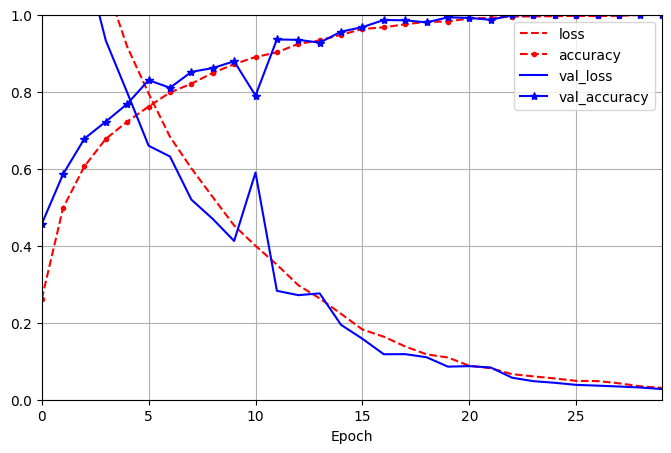

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                   xlim=[0, 29],
                                   ylim=[0, 1],
                                   grid=True,
                                   xlabel="Epoch",
                                   style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [84]:
ann_model.evaluate(*split_into_features_labels(sign_mnist_test, label="Letter"))

225/225 [==============================] - 1s 2ms/step - loss: 1.0589 - accuracy: 0.7651


[1.0588650703430176, 0.7650585770606995]

The model has a score of about `0.765` on the testing data.
This is a vast improvement from the SGDClassifier, which had a score of about `0.611` on the same testing data.

In [95]:
X_new_features, X_new_labels = split_into_features_labels(sign_mnist_test, label="Letter")
X_new_features = X_new_features[5:9]
X_new_labels = X_new_labels[5:9]

ann_model.predict(X_new_features).argmax(axis=-1), X_new_labels

1/1 [==============================] - 0s 22ms/step


(array([ 2, 16, 18,  7]),
 2155     2
 1535    16
 1817    18
 3256     7
 Name: Letter, dtype: int64)

The model correctly predicts these instances of the testing data.

### Second ANN
Create a new ANN using the sequential API to train a multiclass classifier model with different hyperparameters values (add more hidden layers, add more neurons in the layers, increase epoch number, change the loss function and the optimizer)
- Evaluate the new ANN using the test set to estimate the generalization. **Write your observations (compare the score of the new ANN and the previous ANN in question 7)**

In [86]:
import tensorflow as tf
tf.random.set_seed(42)
ann_model2 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[784]),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(25, activation="softmax")
])

In [87]:
ann_model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_32 (Dense)            (None, 200)               157000    
                                                                 
 dense_33 (Dense)            (None, 200)               40200     
                                                                 
 dense_34 (Dense)            (None, 100)               20100     
                                                                 
 dense_35 (Dense)            (None, 25)                2525      
                                                                 
Total params: 219825 (858.69 KB)
Trainable params: 219825 (858.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
ann_model2.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

In [89]:
train_features, train_labels = split_into_features_labels(sign_mnist_train, label="Letter")
history = ann_model2.fit(train_features, train_labels,
                        epochs=30,
                        validation_data=split_into_features_labels(sign_mnist_validation, label="Letter"))

Epoch 1/30
733/733 [==============================] - 6s 7ms/step - loss: 1.9365 - accuracy: 0.3818 - val_loss: 1.3047 - val_accuracy: 0.5375
Epoch 2/30
733/733 [==============================] - 4s 5ms/step - loss: 0.8871 - accuracy: 0.7054 - val_loss: 0.5444 - val_accuracy: 0.8265
Epoch 3/30
733/733 [==============================] - 4s 5ms/step - loss: 0.4867 - accuracy: 0.8343 - val_loss: 0.3862 - val_accuracy: 0.8702
Epoch 4/30
733/733 [==============================] - 5s 7ms/step - loss: 0.3043 - accuracy: 0.8979 - val_loss: 0.1837 - val_accuracy: 0.9395
Epoch 5/30
733/733 [==============================] - 4s 5ms/step - loss: 0.1784 - accuracy: 0.9420 - val_loss: 0.0825 - val_accuracy: 0.9780
Epoch 6/30
733/733 [==============================] - 4s 5ms/step - loss: 0.1263 - accuracy: 0.9602 - val_loss: 0.4218 - val_accuracy: 0.8553
Epoch 7/30
733/733 [==============================] - 5s 7ms/step - loss: 0.0921 - accuracy: 0.9704 - val_loss: 0.0222 - val_accuracy: 0.9965
Epoch 

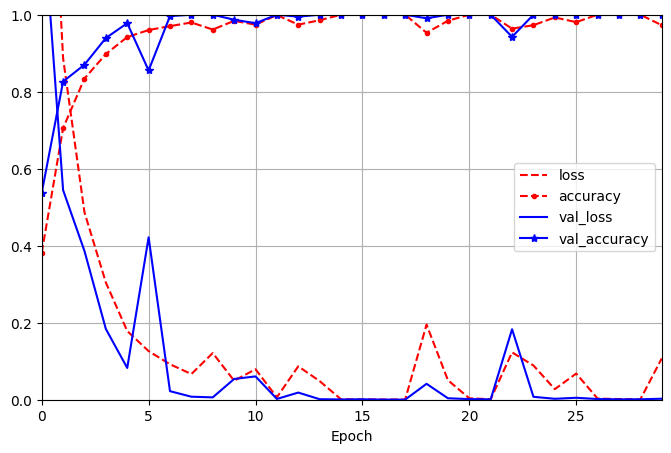

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                   xlim=[0, 29],
                                   ylim=[0, 1],
                                   grid=True,
                                   xlabel="Epoch",
                                   style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [91]:
ann_model2.evaluate(*split_into_features_labels(sign_mnist_test, label="Letter"))

225/225 [==============================] - 1s 2ms/step - loss: 0.8685 - accuracy: 0.8228


[0.8685364723205566, 0.8227830529212952]

This model performs slightly better from the previous neural network.
This one has a score of `0.822` while the previous one had a score of `0.765`.
The difference between this model and the previous is that we changed the optimizer to `adam` and added another hidden layer with 200 nodes.

In [96]:
X_new_features, X_new_labels = split_into_features_labels(sign_mnist_test, label="Letter")
X_new_features = X_new_features[5:9]
X_new_labels = X_new_labels[5:9]

ann_model2.predict(X_new_features).argmax(axis=-1), X_new_labels

1/1 [==============================] - 0s 20ms/step


(array([ 2, 16, 18,  7]),
 2155     2
 1535    16
 1817    18
 3256     7
 Name: Letter, dtype: int64)

The model correctly predicts these instances of the testing data.

## Part 2
In this part you’ll use the “Data for Admission in the University” dataset from assignment 2 and assignment 4 to implement a regression ANN.

### Setting Up The Data
Download the data and load it as a csv file.

Split the data into train data (0.85) and test data (0.15).

Hold out the last 50 instances from the training set for validation.

### Creating ANN
Create ANN using the sequential API to train a regression model to predict the chance of
admission as follows:


Build the neural network with 3 dense hidden layers (100 neurons in each
hidden layer).

Compile the neural network with `loss="mse"`, `optimizer=Adam`, `metrics=['mse']`

Train the neural network.

Evaluate the ANN using the test set to estimate the generalization.
**Write your observations (compare the result of ANN with the linear regression medels in assignment 4 part 1)**

Use the ANN to predict `X_new = XTest[2]` and `X_new = XTest[50]`.
Did the ANN classify all images correctly? Prove your answer.